
<h1 align="center"> k-Nearest Neighbors algorithm and hyperparameter tuning </h1>

<pre align="left"> September 10th 2025               <i> Author: Igor Colin </i></pre>
* * *

**Goals**
- Implement a **k-Nearest Neighbors (kNN)** classifier **from scratch** in NumPy.
- Use the **Breast Cancer Wisconsin** dataset (scikit-learn).
- Measure and compare **training time** and **inference time** **as a function of the training sample size**.
- Analyze **train/test accuracy** as a function of **k**.
- Visualize and discuss **overfitting vs underfitting** with 2D decision boundaries.

> A 🔧 **Question** indicates that you need to fill **TODO** blocks in the following cell.

> Whenever you encounter a 🧠 **Question**, answer it in the same block.

## 1) Setup

In [2]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

import time

np.random.seed(42)

def describe_split(X_train, X_test, y_train, y_test):
    print(f"Train: X={X_train.shape}, y={y_train.shape} | Test: X={X_test.shape}, y={y_test.shape}")


## 2) Load & preprocess the data

In [3]:

data = load_breast_cancer() 
X = data.data.astype(float) 
y = data.target.astype(int) 
feature_names = data.feature_names
target_names = data.target_names

print("Classes:", list(target_names))
print("Num samples:", X.shape[0], "| Num features:", X.shape[1])

# Standardize (important for kNN)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Train/test split (keep class balance with stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.25, stratify=y, random_state=42
)
describe_split(X_train, X_test, y_train, y_test)

Classes: ['malignant', 'benign']
Num samples: 569 | Num features: 30
Train: X=(426, 30), y=(426,) | Test: X=(143, 30), y=(143,)


🧠 **Question 1.** If we did not standardize features, what might you expect to happen and why?

- Standardization is important because **kNN** algorithm measuring distances. Without it, larger numeric values will dominate the distance calcul. This causes the algorithm to be biased toward those features and effectively ignore features with smaller scales, regardless of their actual importance. 


## 3) Implement `KNNClassifier` (fill-in-the-blanks)
We follow the `fit`/`predict` API of scikit-learn. For `kNNClassifier`, `fit` simply memorizes the training data.

🔧 **Question 2.** Complete `_predict_one`, so it computes Euclidean distances from argument `x` to all training points, sort, take top-`k`, and majority vote.



In [4]:

class KNNClassifier:
    def __init__(self, n_neighbors=5):
        assert isinstance(n_neighbors, int) and n_neighbors >= 1
        self.k = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """Training = memorize the training data."""
        # TODO: store numpy arrays
        self.X_train = X
        self.y_train = y

    def _predict_one(self, x):
        """Predict the class of a single point by majority vote among k nearest neighbors."""
        
        # TODO 1: distances from x to each sample of X_train
        distances = [np.linalg.norm(x - x1) for x1 in self.X_train]
        # TODO 2: sort indices
        idx_sorted = np.argsort(distances) # Trie les indices par distance croissante
        # TODO 3: take top-k
        k_idx = idx_sorted[:self.k] # on ne garde que les k premiers indices
        
        # majority vote
        votes = self.y_train[k_idx]
        return int(np.argmax(np.bincount(votes)))

    def predict(self, X):
        X = np.atleast_2d(X)
        return np.array([self._predict_one(row) for row in X], dtype=int)


## 4) Timing **vs training sample size** (fixed k)
Now we measure **training** and **inference** time as we increase the **training sample size**.

To do so, we use a fixed `k_time` (_e.g._, 11), and for each size `n_train_sub`, create a **stratified** subset of the training set of that size.

🔧 **Question 3.** Complete the `for` loop to record:
  - `fit` time
  - `predict` time

🧠 **Bonus:** Why is using a stratified subset helpful here? (check `StratifiedShuffleSplit` documentation to learn about it) 

- Here `StratifiedShuffleSplit` allows us to implement cross validation, it's helpful to avoid baised results.

In [5]:
sizes = np.arange(50, 401, 50)

k_time = 11  # fixed k for timing
fit_times = []
pred_times = []

for n_train_sub in sizes:
    # Build a stratified subset of size n_sub from the training set
    strat_shuffler = StratifiedShuffleSplit(n_splits=1, train_size=n_train_sub, random_state=42)
    (idx_sub, _), = strat_shuffler.split(X_train, y_train)
    X_sub = X_train[idx_sub]
    y_sub = y_train[idx_sub]

    knn = KNNClassifier(n_neighbors=k_time)

    # TODO: measure fit time
    t_init = time.time()
    knn.fit(X_sub, y_sub)
    t_end = time.time()
    fit_times.append(t_end - t_init)
    # TODO: measure predict time (on X_test)
    t_init1 = time.time()
    predict = knn.predict(X_test)
    t_end1 = time.time()
    pred_times.append(t_end1 - t_init1)
    
    

print("sizes:", sizes)
print("fit_times:", fit_times)
print("pred_times:", pred_times)

sizes: [ 50 100 150 200 250 300 350 400]
fit_times: [1.6689300537109375e-06, 9.5367431640625e-07, 0.0, 9.5367431640625e-07, 9.5367431640625e-07, 9.5367431640625e-07, 9.5367431640625e-07, 0.0]
pred_times: [0.00957632064819336, 0.016027212142944336, 0.023378849029541016, 0.031100988388061523, 0.039663076400756836, 0.04747605323791504, 0.055905818939208984, 0.06360483169555664]


Check your implementation graphically using the following code.

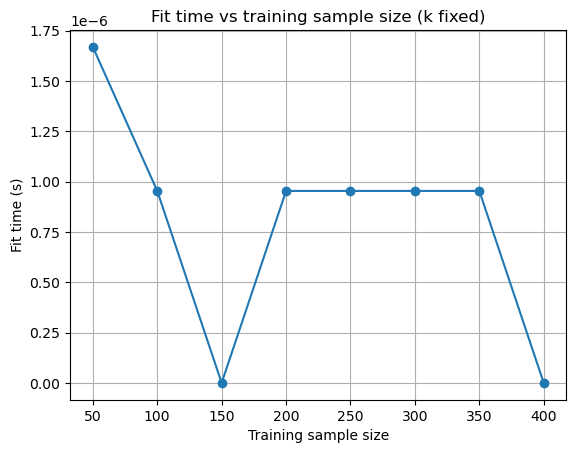

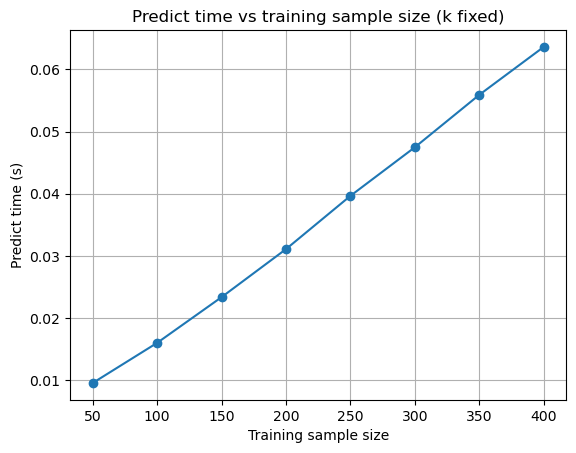

In [6]:

plt.figure()
plt.plot(sizes, fit_times, marker="o")
plt.xlabel("Training sample size")
plt.ylabel("Fit time (s)")
plt.title("Fit time vs training sample size (k fixed)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(sizes, pred_times, marker="o")
plt.xlabel("Training sample size")
plt.ylabel("Predict time (s)")
plt.title("Predict time vs training sample size (k fixed)")
plt.grid(True)
plt.show()

🧠 **Question 4.** Describe and explain the relation between inference time and sample size.

- There is a linear relation between inference time and sample size. As the number of training samples increases, the time required to make a prediction increases proportionally. Furthermor, no matter the size of the training set, fit time is around 0 and 1 second.


## 5) Train/Test accuracy vs k

Depending on the value of `k`, our classifier may produce different predictions. One way to select a value for the number of neighbors `k` is to analyze the accuracy on the test set.

🔧 **Question 5.** Complete the `for` loop below so that we store the train/test accuracy for several values of `k`

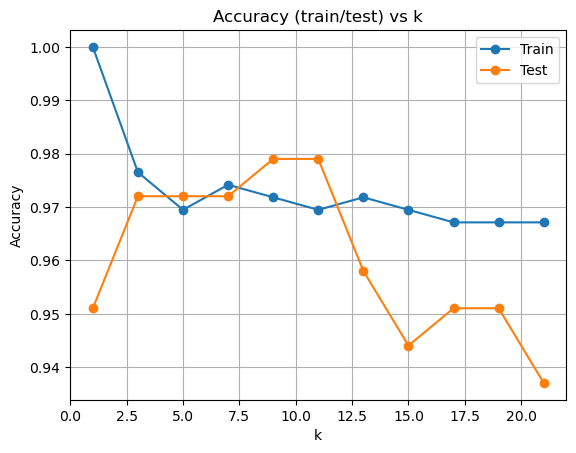

In [7]:
def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()
    
ks = np.arange(1, 22, 2)
train_scores = []
test_scores = []

for k in ks:
    knn = KNNClassifier(n_neighbors=int(k))
    # TODO: fit on full training set
    knn.fit(X_train, y_train)
    # TODO: make predictions
    y_tr = knn.predict(X_train)
    y_te = knn.predict(X_test)
    train_scores.append(accuracy(y_train, y_tr))
    test_scores.append(accuracy(y_test, y_te))

plt.figure()
plt.plot(ks, train_scores, marker="o", label="Train")
plt.plot(ks, test_scores, marker="o", label="Test")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy (train/test) vs k")
plt.legend()
plt.grid(True)
plt.show()


🧠 **Question 6.** Discuss the evolution of the train accuracy w.r.t. `k`. Same with the test accuracy. Which value should we pick for `k`?

- **Train accuracy** starts perfectly at 1.00 for k = 1.0, beacause the model is complex. It decreases as $k$ increases because the model becomes simpler and makes more errors on the training set.
- **Test accuracy** is like a parabol, very bad at the begining (overfiting), the best at k = 9 or k = 11, and decreases as k increases (underfiting).




## 7) Decision boundaries (2D) and overfitting

Another way to notice overfitting is to look at decision boundaries, in particular their smoothness.

🔧 **Question 7.** Complete the `plot_decision_boundary_2d` function so that it fits a 2D projection of the dataset and plot the decision boundary for 3 values of `k` (typically 1, 21 and the value you have picked in **Q6**).


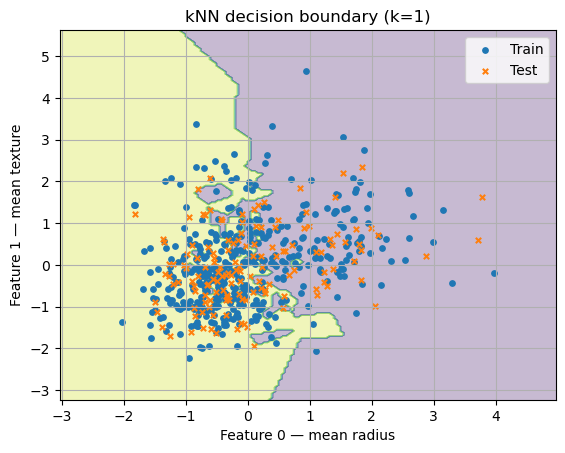

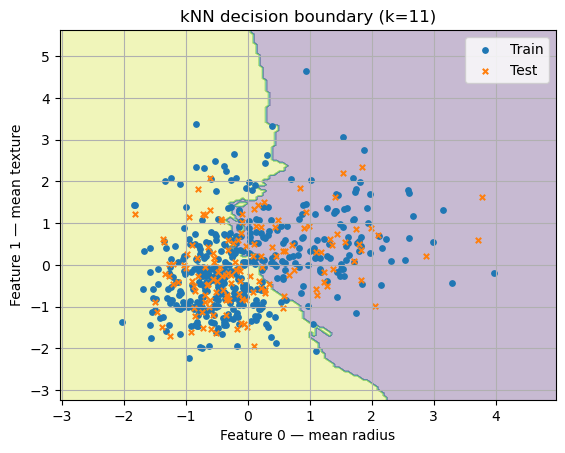

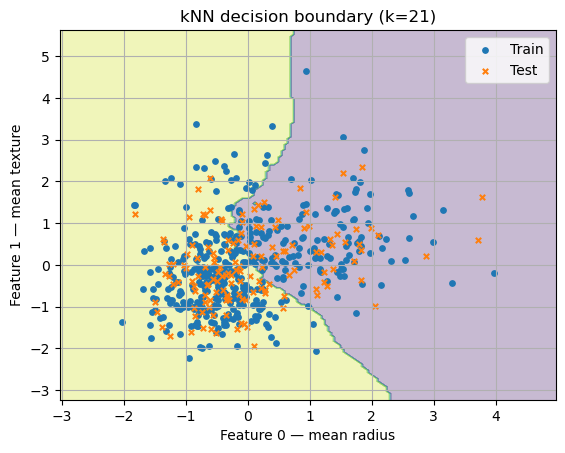

In [9]:
def plot_decision_boundary_2d(X_train, y_train, X_test, y_test, feature_idx=(0,1), k=5, h=0.05):
    i, j = feature_idx
    Xtr = X_train[:, [i, j]]
    Xte = X_test[:, [i, j]]

    knn = KNNClassifier(n_neighbors=k)
    # TODO: fit on 2D projected training data
    knn.fit(Xtr,y_train)
    x_min, x_max = Xtr[:,0].min() - 1.0, Xtr[:,0].max() + 1.0
    y_min, y_max = Xtr[:,1].min() - 1.0, Xtr[:,1].max() + 1.0
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    

    x_min, x_max = Xtr[:,0].min() - 1.0, Xtr[:,0].max() + 1.0
    y_min, y_max = Xtr[:,1].min() - 1.0, Xtr[:,1].max() + 1.0
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = knn.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(Xtr[:,0], Xtr[:,1], s=15, label="Train")
    plt.scatter(Xte[:,0], Xte[:,1], s=15, marker="x", label="Test")
    plt.xlabel(f"Feature {i} — {feature_names[i]}")
    plt.ylabel(f"Feature {j} — {feature_names[j]}")
    plt.title(f"kNN decision boundary (k={k})")
    plt.legend()
    plt.grid(True)
    plt.show()

# TODO: plot the decision boundary for various values of k
k_best = 11

for k_val in [1, k_best, 21]:
    plot_decision_boundary_2d(X_train, y_train, X_test, y_test, feature_idx=(0,1), k=k_val, h=0.05)

🧠 **Question 8.** Comment the shape of the decision boundary for the different values of `k`.

- k = 1, the boundary shape is highly irregular and jagged with sharp peaks and valleys. Each training point creates a small region around it. This is overfitting, the model memorizes noise in the data instead of learning the true pattern.

- k = 11, the boundary is smooth and regular. It cleanly separates the two classes without creating artificial pockets or erratic regions. This represents a good balance between model complexity and generalization to unseen data.

- k = 21: The boundary becomes very smooth, almost linear. The model "over-smooths" and loses the ability to capture the true structure of the data. This is underfitting the model is too simple and misses important patterns.